In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf 
import os
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
data_dir = pathlib.Path("dataset").with_suffix("")
image_count = len(list(data_dir.glob("*/*.jpg")))
print("Found {} images".format(image_count))


Found 2572 images


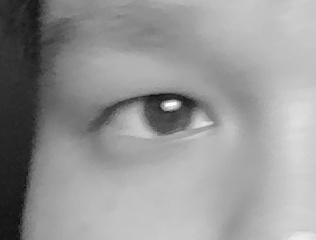

In [3]:
eyes_open = list(data_dir.glob("eyes_open/*"))
PIL.Image.open(str(eyes_open[0]))

In [4]:
batch_size = 100
img_height = 50
img_width = 70

In [5]:

training_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.3,
  subset = "training",
  seed=123,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  shuffle=True,
  labels="inferred",
  color_mode="rgb"
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.3,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  labels="inferred",
  color_mode="rgb"
)

Found 2572 files belonging to 2 classes.
Using 1801 files for training.
Found 2572 files belonging to 2 classes.
Using 771 files for validation.


In [6]:
class_names = training_dataset.class_names
print("Using class names with length {}".format(len(class_names)))
print(class_names)

Using class names with length 2
['eyes_closed', 'eyes_open']


2024-05-07 23:49:51.768601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


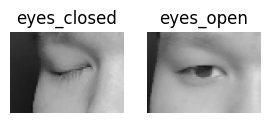

In [7]:
plt.figure(figsize=(5, 5))
for images, labels in training_dataset.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

32 is the amount of images in a single training batch
80 and 50 is the width and height of the image
3 is the array of the pixel which contains tha Red Green and Blue values

In [8]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  

(100, 50, 70, 3)
(100,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [10]:
#normalize layers which turns 0 ,255 to 0, 1
normalization_layer = layers.Rescaling(1./255)
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/Users/christianharjuno/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
classes_amount = len(class_names)

2024-05-07 23:49:52.432570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


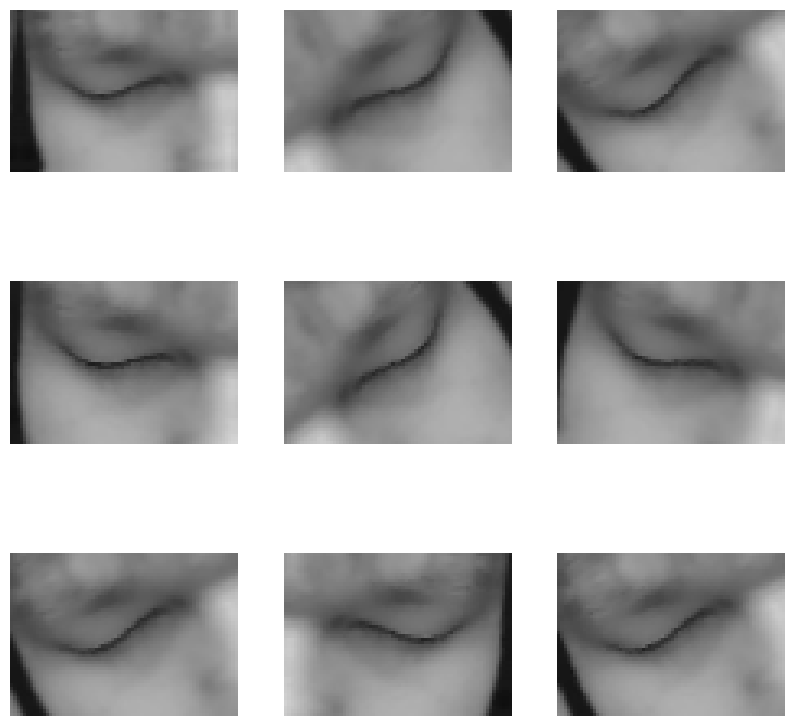

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
tf.keras.backend.clear_session()
model = Sequential([
  normalization_layer,
  data_augmentation,
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256,  activation="relu"),
  layers.Dense(classes_amount, activation="softmax"),
])

In [14]:
model.build()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [15]:
epochs = 100
tf.keras.backend.clear_session()
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)
model.summary()

Epoch 1/100


/Users/christianharjuno/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5156 - loss: 0.7064 - val_accuracy: 0.5564 - val_loss: 0.6724
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5722 - loss: 0.6660 - val_accuracy: 0.5564 - val_loss: 0.6131
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6911 - loss: 0.5605 - val_accuracy: 0.9637 - val_loss: 0.2388
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9133 - loss: 0.2792 - val_accuracy: 0.9598 - val_loss: 0.1368
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9558 - loss: 0.1718 - val_accuracy: 0.9572 - val_loss: 0.1903
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9458 - loss: 0.1765 - val_accuracy: 0.9533 - val_loss: 0.2144
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9485 - loss: 0.1857 - val_accuracy: 0.9637 - val_loss: 0.1305
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9605 - loss: 0.1505 - val_accuracy: 0.9611 - val_l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │     1,573,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,000,648 (19.08 MB)

 Trainable params: 1,666,882 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,333,766 (12.72 MB)

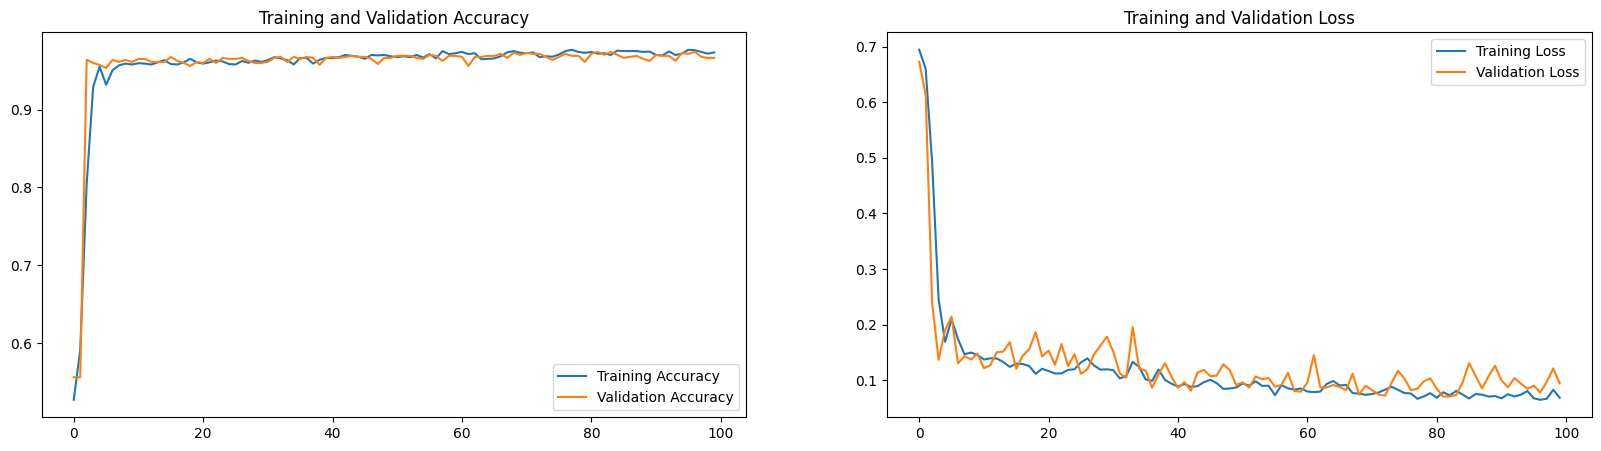

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:

img = tf.keras.utils.load_img(
    "samples/11.jpg", target_size=(img_height, img_width), color_mode="rgb"
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(predictions)
model.save("trained.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
This image most likely belongs to eyes_open with a 70.75 percent confidence.
[[0.05839686 0.9416032 ]]
